In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/notebook_template.ipynb"">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/notebook_template.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

This Colab introduces Featurestore, a managed cloud service for machine learning engineers and data scientists to store, serve manage and share machine learning features at scale.

This Colab assumes that you understand basic Google cloud concepts such as [Project](https://cloud.google.com/storage/docs/projects), [Storage](https://cloud.google.com/storage) and [AI Platform (Unified)](https://cloud.google.com/ai-platform-unified/docs). Some machine learning knowledge is also helpful but not required.

### Dataset

This Colab uses the movie recommentation as an example throughout all the sessions. The task is to train a model to predict if a user is going to watch a movie and serve this model online. 

### Objective

In this notebook, you will learn how to:

    * How to import your features into the Featurestore.
    * How to serve online prediction request using the imported features.
    * How to access imported features in offline jobs, such as training jobs.

### Costs 

This tutorial uses billable components of Google Cloud:

* AI Platform (Unified)
* Cloud Storage
* Cloud Bigtable

Learn about [AI Platform (Unified)
pricing](https://cloud.google.com/ai-platform-unified/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or AI Platform Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

### Install additional packages

For this Colab, you need the AI Platform SDK.

In [ ]:
# Uninstall previous version of google-cloud-aiplatform SDK, if any.
!pip uninstall google-cloud-aiplatform -y
# Install the latest public release version
# !pip install -U google-cloud-aiplatform
# Install the testing version
!pip install git+https://github.com/googleapis/python-aiplatform.git@main-test

### Restart the kernel

After you install the SDK, you need to restart the notebook kernel so it can find the packages. You can restart kernel from *Kernel -> Restart Kernel*, or running the following:

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Verify that the SDK has been successfully installed:

In [ ]:
!pip freeze | grep aiplatform

## Before you begin

### Select a GPU runtime

**Make sure you're running this notebook in a GPU runtime if you have that option. In Colab, select "Runtime --> Change runtime type > GPU"**

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the AI Platform (Unified) API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component). {TODO: Update the APIs needed for your tutorial. Edit the API names, and update the link to append the API IDs, separating each one with a comma. For example, container.googleapis.com,cloudbuild.googleapis.com}

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [ ]:
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Otherwise, set your project ID here.

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "python-docs-samples-tests"  # @param {type:"string"}

### Authenticate your Google Cloud account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "AI Platform"
into the filter box, and select
   **AI Platform Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on AI Platform, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

## Prepare for output table

You need a BigQuery dataset to host the output data in `us-central1`: on the [BigQuery console](https://console.cloud.google.com/bigquery), click the `CREATE DATASET` button. Note that it's **very important** to choose the correct location, instead of using default location, as follows:



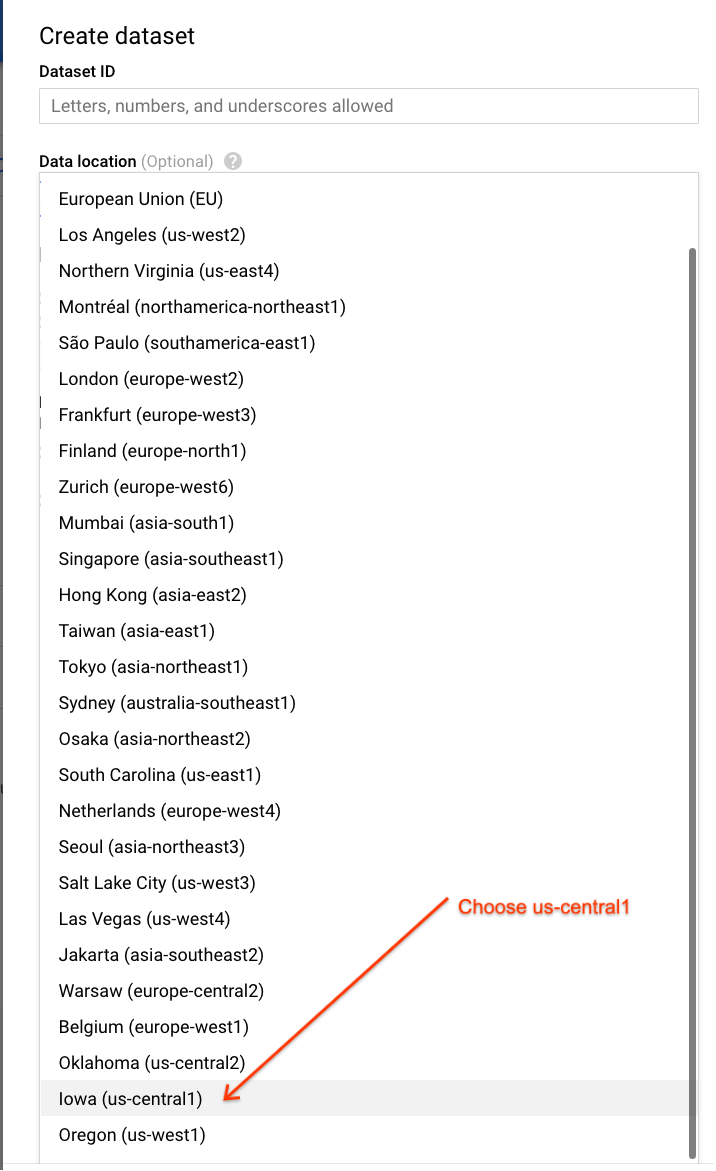

Then input the name of the dataset you just created and specified the name of the table you want to store the output later. 

**Make sure that the table name does NOT already exist**

In [ ]:
# Output data set, as created in the step 1.
DESTINATION_DATA_SET = "movie_prediction"  #@param {type:"string"}
# Output table. Make sure that the table does NOT already exist; the BatchReadFeatureValues API cannot overwrite an existing table
DESTINATION_TABLE_NAME = "training_data" #@param {type:"string"}

DESTINATION_PATTERN = "bq://{project}.{dataset}.{table}"
DESTINATION_TABLE_URI = DESTINATION_PATTERN.format(project=PROJECT_ID,
    dataset=DESTINATION_DATA_SET, table=DESTINATION_TABLE_NAME)

### Import libraries and define constants

In [ ]:
# Other than project ID, location and featurestore ID and endpoints needs to be set
LOCATION = "us-central1"  #@param {type:"string"}
API_ENDPOINT = "us-central1-aiplatform.googleapis.com"  #@param {type:"string"}
INPUT_CSV_FILE = "gs://cloud-aiplatform-featurestore-us-central1/read_entity_instance.csv"

In [ ]:
from google.api_core import operations_v1
from google.cloud.aiplatform_v1beta1 import FeaturestoreOnlineServingServiceClient
from google.cloud.aiplatform_v1beta1 import FeaturestoreServiceClient
from google.cloud.aiplatform_v1beta1.types import featurestore_online_service as featurestore_online_service_pb2
from google.cloud.aiplatform_v1beta1.types import entity_type as entity_type_pb2
from google.cloud.aiplatform_v1beta1.types import feature as feature_pb2
from google.cloud.aiplatform_v1beta1.types import featurestore as featurestore_pb2
from google.cloud.aiplatform_v1beta1.types import featurestore_service as featurestore_service_pb2
from google.cloud.aiplatform_v1beta1.types import io as io_pb2
from google.cloud.aiplatform_v1beta1.types import FeatureSelector
from google.cloud.aiplatform_v1beta1.types import IdMatcher

# Create admin_client for CRUD and data_client for reading feature values.
admin_client = FeaturestoreServiceClient(
    client_options={"api_endpoint": API_ENDPOINT})
data_client = FeaturestoreOnlineServingServiceClient(
    client_options={"api_endpoint": API_ENDPOINT})

# Represents featurestore resource path.
BASE_RESOURCE_PATH = admin_client.common_location_path(PROJECT_ID, LOCATION)

## Terminology and Concept

### Featurestore Data model

Feature store organizes data with the following 3 important hierarchical concepts:
```
Featurestore -> EntityType -> Feature
```
* **Featurestore**: the place to store your features
* **EntityType**: under a Featurestore, an *EntityType* describes an object to be modeled, real one or virtual one.
* **Feature**: under an EntityType, a *feature* describes an attribute of the EntityType

In the movie prediction example, you will create a feature store called *movie_prediction*. This store has 2 entity types: *Users* and *Movies*. The Users entity has age, gender, liked genres features. The Movies entity has genres, average rating features.





## Creating Featurestore and Defining Schema

### Create Featurestore

The method to create a featurestore returns a
[long-running operation](https://google.aip.dev/151) (LRO). An LRO starts an asynchronous job. LROs are returned for other API
methods too, such as updating or deleting a featurestore. Calling
`create_fs_lro.result()` waits for the LRO to complete.

In [ ]:
FEATURESTORE_ID = "movie_prediction"
create_lro = admin_client.create_featurestore(
    featurestore_service_pb2.CreateFeaturestoreRequest(
        parent=BASE_RESOURCE_PATH,
        featurestore_id=FEATURESTORE_ID,
        featurestore=featurestore_pb2.Featurestore(
            display_name="Featurestore for movie prediction",
            online_serving_config=featurestore_pb2.Featurestore
            .OnlineServingConfig(fixed_node_count=3))))

In [ ]:
# Wait for LRO to finish and get the LRO result.
print(create_lro.result())

You can use [GetFeaturestore](https://cloud.google.com/ai-platform-unified/featurestore/docs/reference/rpc/google.cloud.aiplatform.v1beta1#google.cloud.aiplatform.v1beta1.FeaturestoreService.GetFeaturestore) or [ListFeaturestores](https://cloud.google.com/ai-platform-unified/featurestore/docs/reference/rpc/google.cloud.aiplatform.v1beta1#google.cloud.aiplatform.v1beta1.FeaturestoreService.ListFeaturestores) to check if the featurestore was successfully created. The following example gets the details of the featurestore.


In [ ]:
admin_client.get_featurestore(name = admin_client.featurestore_path(PROJECT_ID, LOCATION, FEATURESTORE_ID))

### Create Entity Type

In [ ]:
# Create users entity type
users_entity_type_lro = admin_client.create_entity_type(
    featurestore_service_pb2.CreateEntityTypeRequest(
        parent=admin_client.featurestore_path(PROJECT_ID, LOCATION, FEATURESTORE_ID),
        entity_type_id="users", 
        entity_type=entity_type_pb2.EntityType(description="Users entity")))

# Similarly, wait for EntityType creation operation.
print(users_entity_type_lro.result())

In [ ]:
# Create movies entity type
movies_entity_type_lro = admin_client.create_entity_type(
    featurestore_service_pb2.CreateEntityTypeRequest(
        parent=admin_client.featurestore_path(PROJECT_ID, LOCATION, FEATURESTORE_ID),
        entity_type_id="movies", 
        entity_type=entity_type_pb2.EntityType(description="Movies entity")))

# Similarly, wait for EntityType creation operation.
print(movies_entity_type_lro.result())

### Create Feature

In [ ]:
# Create features for the 'users' entity
admin_client.batch_create_features(
    parent=admin_client.entity_type_path(PROJECT_ID, LOCATION, FEATURESTORE_ID, "users"),
    requests=[
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.INT64,
                description="User age"),
            feature_id="age"),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.STRING,
                description="User gender"),
            feature_id="gender"),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.STRING_ARRAY,
                description="An array of genres that this user liked"),
            feature_id="liked_genres")
    ]).result()

In [ ]:
# Create features for movies type
admin_client.batch_create_features(
    parent=admin_client.entity_type_path(PROJECT_ID, LOCATION, FEATURESTORE_ID, "movies"),
    requests=[
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.STRING,
                description="The title of the movie"),
            feature_id="title"),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.STRING,
                description="The genres of the movie"),
            feature_id="genres"),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.DOUBLE,
                description="The average rating for the movie, range is [1.0-5.0]"),
            feature_id="average_rating")
    ]).result()

## Search created features

While the [ListFeatures](https://cloud.google.com/ai-platform-unified/featurestore/docs/reference/rpc/google.cloud.aiplatform.v1beta1#google.cloud.aiplatform.v1beta1.FeaturestoreService.ListFeatures) method allows you to easily view all features of a single
entity type, the [SearchFeatures](https://cloud.google.com/ai-platform-unified/featurestore/docs/reference/rpc/google.cloud.aiplatform.v1beta1#google.cloud.aiplatform.v1beta1.FeaturestoreService.SearchFeatures) method searches across all featurestores
and entity types in a given location (such as `us-central1`). This can help you discover features that were created by someone else.

You can query based on feature properties including feature ID, entity type ID,
and feature description. You can also limit results by filtering on a specific
featurestore, feature value type, and/or labels.

In [ ]:
# Search for all features across all featurestores.
list(admin_client.search_features(location=BASE_RESOURCE_PATH))

Now, narrow down the search to features that are of type `DOUBLE`

In [ ]:
# Search for all features with value type `DOUBLE`
list(
    admin_client.search_features(
        featurestore_service_pb2.SearchFeaturesRequest(
            location=BASE_RESOURCE_PATH, query="value_type=DOUBLE")))

Or, limit the search results to features with specific keywords in their ID and type.

In [ ]:
# Filter on feature value type and keywords.
list(
    admin_client.search_features(
        featurestore_service_pb2.SearchFeaturesRequest(
            location=BASE_RESOURCE_PATH, query="feature_id:title AND value_type=STRING")))

## Import Feature Values

You need to import feature values before you can use them for online/offline serving. In this step, you will learn how to import feature values by calling the ImportFeatureValues API using the python SDK.



### Source Data Format and Layout

As mentioned above, BigQuery table/Avro/CSV are supported. No matter what format you are using, each imported entity *must* have an ID on it, besides features; also, each entity can *optionally* have an timestamp on it, sepecifying when the feature values are generated. This Colab uses Avro as an input, located at this public-available [bucket](https://pantheon.corp.google.com/storage/browser/cloud-samples-data/ai-platform-unified/datasets/featurestore;tab=objects?project=storage-samples&prefix=&forceOnObjectsSortingFiltering=false). The Avro schemas are as follows:

**For the Users entity**:
```
schema = {
  "type": "record",
  "name": "User",
  "fields": [
      {
       "name":"user_id",
       "type":["null","string"]
      },
      {
       "name":"age",
       "type":["null","long"]
      },
      {
       "name":"gender",
       "type":["null","string"]
      },
      {
       "name":"liked_genres",
       "type":{"type":"array","items":"string"}
      },
      {
       "name":"update_time",
       "type":["null",{"type":"long","logicalType":"timestamp-micros"}]
      },
  ]
 }
```

**For the Movies entity**
```
schema = {
 "type": "record",
 "name": "Movie",
 "fields": [
     {
      "name":"movie_id",
      "type":["null","string"]
     },
     {
      "name":"average_rating",
      "type":["null","double"]
     },
     {
      "name":"title",
      "type":["null","string"]
     },
     {
      "name":"genres",
      "type":["null","string"]
     },
     {
      "name":"update_time",
      "type":["null",{"type":"long","logicalType":"timestamp-micros"}]
     },
 ]
}
```

### Import feature values for Users

When importing, specify the following in your request:

*   Data source format: currently support BigQuery table/Avro/CSV
*   Data source URL
*   Destination: feature store/entity types/features to be imported



In [ ]:
import_users_request = featurestore_service_pb2.ImportFeatureValuesRequest(
    entity_type=admin_client.entity_type_path(PROJECT_ID, LOCATION,
                                              FEATURESTORE_ID, "users"),
    avro_source=io_pb2.AvroSource(
        # Source
        gcs_source=io_pb2.GcsSource(uris=["gs://cloud-samples-data-us/ai-platform-unified/datasets/featurestore/users.avro"])
    ),
    entity_id_field="user_id",
    feature_specs=[
        # Features
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(
            id="age"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(
            id="gender"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(
            id="liked_genres"),
    ],
    feature_time_field="update_time",
    worker_count=10)

In [ ]:
# Start to import, will take a couple of minutes
ingestion_lro = admin_client.import_feature_values(import_users_request)

In [ ]:
# Polls for the LRO status and prints when the LRO has completed
ingestion_lro.result()

### Import feature values for Movies

Similarly, import feature values for 'movies' to the feature store.



In [ ]:
import_movie_request = featurestore_service_pb2.ImportFeatureValuesRequest(
    entity_type=admin_client.entity_type_path(PROJECT_ID, LOCATION,
                                              FEATURESTORE_ID, "movies"),
    avro_source=io_pb2.AvroSource(
        gcs_source=io_pb2.GcsSource(uris=["gs://cloud-samples-data-us-central1/ai-platform-unified/datasets/featurestore/movies.avro"])
    ),
    entity_id_field="movie_id",
    feature_specs=[
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(
            id="title"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(
            id="genres"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(
            id="average_rating"),
    ],
    feature_time_field="update_time",
    worker_count=10)

In [ ]:
# Start to import, will take a couple of minutes
ingestion_lro = admin_client.import_feature_values(import_movie_request)

In [ ]:
# Polls for the LRO status and prints when the LRO has completed
ingestion_lro.result()

## Online serving

The
[Online Serving APIs](https://cloud.google.com/ai-platform-unified/featurestore/docs/reference/rpc/google.cloud.aiplatform.v1beta1#featurestoreonlineservingservice)
lets you serve feature values for small batches of entities. It's designed for latency-sensitive service, such as online model prediction. For example, if you have trained a model to predict if a user is going to watch

### Read one entity per request

The ReadFeatureValues API is used to read feature values of one entity; hence
its custom HTTP verb is `readFeatureValues`. By default, the API will return the
latest value of each feature, such as the feature values with the most recent
timestamp.

To read feature values, specify the entity ID and features to read. The response
contains a `header` and an `entity_view`. Each row of data in the `entity_view`
contains one feature value, in the same order of features as listed in the response header.

In [ ]:
# Fetch the following 3 features.
feature_selector = FeatureSelector(
    id_matcher=IdMatcher(
        ids=["age", "gender", "liked_genres"]))

data_client.read_feature_values(
    featurestore_online_service_pb2.ReadFeatureValuesRequest(
        # Fetch from the following feature store/entity type
        entity_type=admin_client.entity_type_path(PROJECT_ID, LOCATION,
                                                  FEATURESTORE_ID, "users"),
        # Fetch the user features whose ID is "alice"
        entity_id="alice",
        feature_selector=feature_selector))

### Read multiple entities per request

To read feature values from multiple entities, use the
StreamingReadFeatureValues API, which is almost identical to the previous
ReadFeatureValues API. Note that, we recommend fetching only a small number of entities when using this API, due to its latency-sensitive nature.

In [ ]:
# Read the same set of features as above, but for multiple entities.
response_stream = data_client.streaming_read_feature_values(
    featurestore_online_service_pb2.StreamingReadFeatureValuesRequest(
        entity_type=admin_client.entity_type_path(PROJECT_ID, LOCATION,
                                                  FEATURESTORE_ID, "users"),
        entity_ids=["alice", "bob"],
        feature_selector=feature_selector))

In [ ]:
# Iterate and process response. Note the first one is always the header only.
for response in response_stream:
  print(response)

Now that you have learned how to featch imported feature values for online serving, the next step is learning how to use imported feature values for offline use cases.

## Batch Serving

Batch Serving is used to fetch a large batch of feature values for high-throughput, typically for training a model or batch prediction. In this section, you will learn how to prepare for training examples by calling the BatchReadFeatureValues API.

### Use case

**The task** is to prepare for a training dataset to train a model, which predicts if a given user will watch a given movie. To achieve this, you need 2 sets of input:

*   Features: you already imported into the feature store.
*   Labels: the groud-truth data recorded that user X has watched movie Y.



To be more specific, the ground-truth observation is described in Table 1 and the desired training dataset is described in Table 2. Here,
we use the `age`, `gender` and `liked_genres` features from `users` and
the `genres` and `average_rating` features from `movies`. Note that only positive examples are in these 2 tables, i.e., you can imagine there is a label column in this table whose values are all `True`.

BatchReadFeatureValues API takes Table 1 as
input, together with the imported feature values, and returns Table 2 for training.

<h4 align="center">Table 1. Ground-truth Data</h4>

users | movies | timestamp            
----- | -------- | -------------------- 
alice  | Cinema Paradiso     | 2019-11-01T00:00:00Z 
bob  | The Shining     | 2019-11-15T18:09:43Z 
...   | ...      | ...     


<h4 align="center">Table 2. Expected Training Data Generated by Batch Read API (Positive Samples)</h4>

timestamp            | entity_type_users | age | gender | liked_genres | entity_type_movies | genres | average_rating  
-------------------- | ----------------- | --------------- | ---------------- | -------------------- | -------- | --------- | ----- 
2019-11-01T00:00:00Z | bob              | 35        | M                | [Action, Crime]                 | The Shining | Horror | 4.8 
2019-11-01T00:00:00Z | alice             | 55        | F                | [Drama, Comedy]                 | Cinema Paradiso | Romance | 4.5 
... | ... | ... | ... | ... | ... | ... | ... 
             

#### Why timestamp?

Note that there is a `timestamp` column in Table 2. This indicates the time when the ground-truth was observed. This is to avoid data inconsistency.

For example, the 1st row of Table 2 indicates that user `alice` watched movie `Cinema Paradiso` on `2019-11-01T00:00:00Z`. The feature store keeps feature values for all timestamps but fetches feature values *only* at the given timestamp during batch serving. For example, on 2019-11-01 alice might be 54 years old, but now alice might be 56; feature store returns `age=54` for alice, instead of `age=56` in the training data, because that is the value of the feature at the observation time.


### Batch Read Feature Values

Assemble the request which specify the following info:

*   Where is the label data, i.e., Table 1.
*   Which features are read, i.e., the column names in Table 2.



In [ ]:
batch_serving_request = featurestore_service_pb2.BatchReadFeatureValuesRequest(
    # featurestore info
    featurestore=admin_client.featurestore_path(PROJECT_ID, LOCATION,
                                                FEATURESTORE_ID),
    # URL for the label data, i.e., Table 1.
    csv_read_instances=io_pb2.CsvSource(
        gcs_source=io_pb2.GcsSource(uris=[INPUT_CSV_FILE])),
    destination=featurestore_service_pb2.FeatureValueDestination(
        bigquery_destination=io_pb2.BigQueryDestination(
            # Output to BigQuery table created earlier
            output_uri=DESTINATION_TABLE_URI)),
    entity_type_specs=[
        featurestore_service_pb2.BatchReadFeatureValuesRequest.EntityTypeSpec(
            # Read the 'age', 'gender' and 'liked_genres' features from the 'users' entity
            entity_type_id="users", 
            feature_selector=FeatureSelector(
                id_matcher=IdMatcher(ids=[
                    # features, use "*" if you want to select all features within this entity type
                    "age",  "gender", "liked_genres"
                ]))),
        featurestore_service_pb2.BatchReadFeatureValuesRequest.EntityTypeSpec(
            # Read the 'average_rating' and 'genres' feature values of the 'movies' entity
            entity_type_id="movies",
            feature_selector=FeatureSelector(
                id_matcher=IdMatcher(
                    ids=["average_rating", "genres"])))
    ])

In [ ]:
# Execute the batch read
batch_serving_lro = admin_client.batch_read_feature_values(batch_serving_request)

In [ ]:
# This long runing operation will poll until the batch read finishes.
batch_serving_lro.result()

After the LRO finishes, you should be able to see the result from the [BigQuery console](https://console.cloud.google.com/bigquery), in the dataset created earlier.

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

You can also keep the project but delete the featurestore:

In [ ]:
admin_client.delete_featurestore(
    name=admin_client.featurestore_path(PROJECT_ID, LOCATION,
                                        FEATURESTORE_ID)).result()